# Computer Vision: Plants Classification

This dataset is based on the **Plant Seedlings Dataset**, which contains images of approximately 960 unique plants belonging to 12 species at several growth stages, with a resolution of about 10 pixels per mm of annotated RGB images.

The dataset includes the following species:


|English     |Latin               |EPPO|
|:-----------|:-------------------|:---|
|Maize       |Zea mays L.         |ZEAMX|
|Common wheat|Triticum aestivum L.|TRZAX|
|Sugar beet|Beta vulgaris var. altissima|BEAVA|
|Scentless Mayweed|Matricaria perforata Mérat|MATIN|
|Common Chickweed|Stellaria media|STEME|
|Shepherd’s Purse|Capsella bursa-pastoris|CAPBP|
|Cleavers|Galium aparine L.|GALAP|
|Charlock|Sinapis arvensis L.|SINAR|
|Fat Hen|Chenopodium album L.|CHEAL|
|Small-flowered Cranesbill|Geranium pusillum|GERSS|
|Black-grass|Alopecurus myosuroides|ALOMY|
|Loose Silky-bent|Apera spica-venti|APESV|

Your mission, should you choose to accept it... consist on:
- create a model that classifies the full range of categories as accuretely as possible.
- save the model for further analysis.

If you're caught of killed during the mission, the dataen team will disavow any knowledge of your actions. This notebook will not self-destruct (disappointing right?). Good luck!


In [28]:
%matplotlib inline

import os
import sys
from time import time
import pickle
import pathlib
import itertools
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model


np.random.seed(42)

## 1. Data Preparation
### 1.1 Load data

In [117]:
PLANT_CLASSES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 
                 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 
                 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
CLASSES_DICT_NAMES = {name: k for k, name in zip(range(len(PLANT_CLASSES)), PLANT_CLASSES)}
CLASSES_DICT_NUM = {k: name for k, name in zip(range(len(PLANT_CLASSES)), PLANT_CLASSES)}

DF_PART1 = "./data/plants_part1.gz"
DF_PART2 = "./data/plants_part2.gz"
DF_PART3 = "./data/plants_part3.gz"
RESHAPE_SIZE = (65, 65, 3)
RANDOM_STATE = 42

CLASSES_DICT_NAMES

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [118]:
df_p1 = pd.read_csv(DF_PART1)
df_p2 = pd.read_csv(DF_PART2)
df_p3 = pd.read_csv(DF_PART3)
df = pd.concat([df_p1, df_p2, df_p3], axis=0)
df.shape
df.columns[:10]
df.dropna(axis = 0, inplace=True)

We can ignore the column 'label'. The column class is the entry we must use for our classification.

The rest of the columns belong to the image and we must reshape those values into 65x65x3 to obtain the images.

In [119]:
df_labels = df[['class']]
df.drop(labels=['label', 'class'], axis=1, inplace=True)
df_images = df.values.reshape(-1, *RESHAPE_SIZE)

# Analysis

Classes are quite heavily skewed so may well be a good idea to either:

- subsample now and randomly choose roughly 200 from each class (lose a lot of data from already limited amount)
- subsample after applying ImageGenerator (preferable as it will keep data varied)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

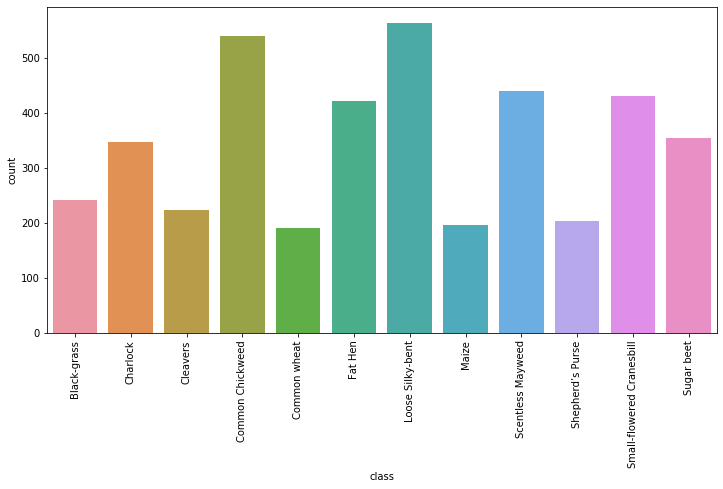

In [120]:
df_label_count= df_labels.groupby('class').agg({'class': ['count']})['class'].reset_index()
plt.figure(figsize=(12,6))
sns.barplot(x='class', y='count', data=df_label_count)
plt.xticks(rotation=90)

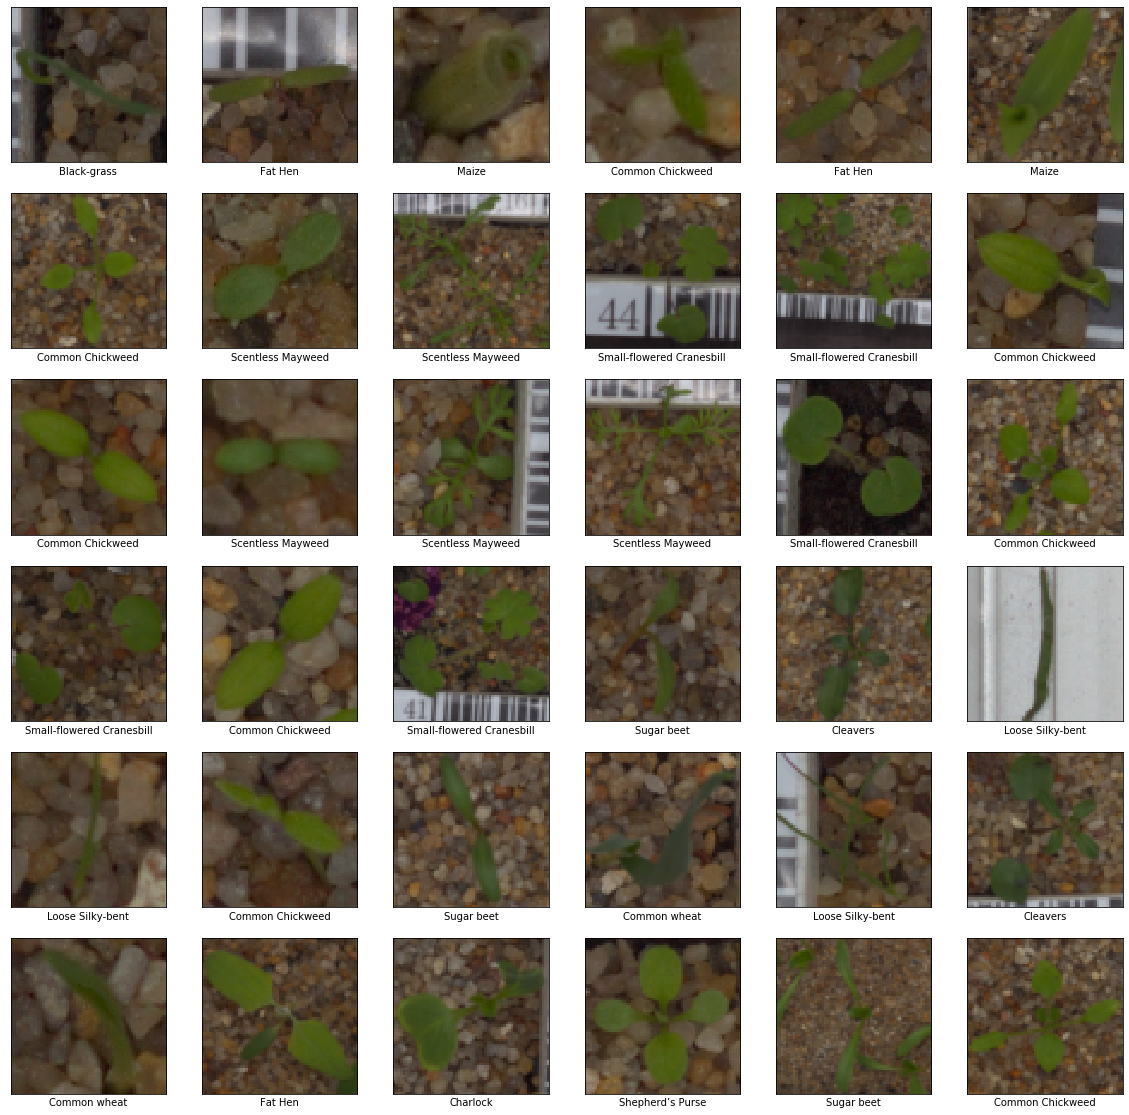

In [121]:
plt.figure(figsize=(20,20))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df_images[i])
    plt.xlabel(df_labels['class'].tolist()[i])
plt.show()

In [128]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(13, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [123]:
df_labels = df_labels['class'].map(CLASSES_DICT_NAMES)

In [124]:
df_labels.fillna(12, inplace=True)
df_labels = df_labels.apply(int)

In [125]:
x_train, x_test, y_train, y_test = train_test_split(df_images, df_labels, test_size=0.2, random_state=42)

In [126]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [ ]:
image_generator.fit(x_train)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metric=['accuracy'])

model.fit_generator(image_generator.flow(x_train, y_train, batch_size=32), 
                    steps_per_epoch=len(x_train) / 32, 
                    epochs=10)

Epoch 1/10
104/103 [==============================] - 14s 138ms/step - loss: 1.7678
Epoch 2/10
104/103 [==============================] - 19s 181ms/step - loss: 1.6522
Epoch 3/10
104/103 [==============================] - 17s 167ms/step - loss: 1.5571
Epoch 4/10
104/103 [==============================] - 16s 156ms/step - loss: 1.4195
Epoch 5/10
104/103 [==============================] - 16s 151ms/step - loss: 1.3813
Epoch 6/10
104/103 [==============================] - 16s 151ms/step - loss: 1.3368
Epoch 7/10
104/103 [==============================] - 19s 184ms/step - loss: 1.2842
Epoch 8/10
 64/103 [=================>............] - ETA: 2:23 - loss: 1.2447